In [1]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
import requests
from io import BytesIO
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


MobileNetV2 Architecture:

    A lightweight CNN optimized for mobile devices using depthwise convolutions and inverted residual blocks.

Input Dimensions:

    Input images must be resized to (3, 224, 224) (RGB, 224x224 pixels).

Preprocessing:

    Images are resized, converted to tensors, and normalized using ImageNet statistics:

    Mean: [0.485, 0.456, 0.406]

    Std: [0.229, 0.224, 0.225]

Model Modification:

    The final classifier layer is replaced with a new layer to match the desired number of output classes.

Output Dimensions:

    If num_classes=10, the output shape will be (batch_size, 10).

In [4]:
url = "https://cdn.pixabay.com/photo/2024/02/28/07/42/european-shorthair-8601492_1280.jpg"
response = requests.get(url)
if response.status_code == 200:  
    print("Image downloaded successfully!")
    img = Image.open(BytesIO(response.content))
else:
    raise Exception("Failed to download the image. Check the URL.")

image_path = "cat_image.jpg"
img.save(image_path)

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
model.eval()

transform_pipeline = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_image = Image.open(image_path).convert("RGB")
processed_image = transform_pipeline(input_image).unsqueeze(0)

with torch.no_grad():
    prediction_logits = model(processed_image)

predicted_probs = torch.nn.functional.softmax(prediction_logits[0], dim=0)

top_predictions = torch.topk(predicted_probs, 3)
top_indices = top_predictions.indices
top_values = top_predictions.values

imagenet_classes_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
class_labels_response = requests.get(imagenet_classes_url)
class_labels = class_labels_response.json()

print("\n--- Top 3 Predicted Classes ---")
for i, idx in enumerate(top_indices):
    class_name = class_labels[idx]
    probability = top_values[i].item()
    print(f"Rank {i + 1}: {class_name} ({probability:.2%} confidence)")


Image downloaded successfully!


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 88.1MB/s]



--- Top 3 Predicted Classes ---
Rank 1: tabby cat (22.54% confidence)
Rank 2: tiger cat (21.51% confidence)
Rank 3: Egyptian Mau (11.49% confidence)


In [5]:
data_dir = "./flower_data"
batch_size = 32

train_dataset = Flowers102(root=data_dir, split='train', download=True, transform=transform_pipeline)
val_dataset = Flowers102(root=data_dir, split='val', download=True, transform=transform_pipeline)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Oxford 102 Flower Dataset loaded!")

100%|██████████| 344862509/344862509 [00:14<00:00, 23309887.26it/s]


Extracting flower_data/flowers-102/102flowers.tgz to flower_data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 275450.11it/s]


100%|██████████| 14989/14989 [00:00<00:00, 7437409.52it/s]


Oxford 102 Flower Dataset loaded!


In [6]:
for param in model.features.parameters():
    param.requires_grad = False

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [7]:
model = model.to(device)

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss, correct = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct.double() / len(train_loader.dataset)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc.item())

        # Validation phase
        model.eval()
        running_loss, correct = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = correct.double() / len(val_loader.dataset)
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc.item())

        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10
Train Loss: 5.8834, Train Acc: 0.0127
Val Loss: 4.4901, Val Acc: 0.0471
Epoch 2/10
Train Loss: 3.8683, Train Acc: 0.1588
Val Loss: 3.5690, Val Acc: 0.2088
Epoch 3/10
Train Loss: 2.8501, Train Acc: 0.4520
Val Loss: 2.9390, Val Acc: 0.4059
Epoch 4/10
Train Loss: 2.1204, Train Acc: 0.7088
Val Loss: 2.4317, Val Acc: 0.5451
Epoch 5/10
Train Loss: 1.5902, Train Acc: 0.8235
Val Loss: 2.0774, Val Acc: 0.6363
Epoch 6/10
Train Loss: 1.1830, Train Acc: 0.9186
Val Loss: 1.8395, Val Acc: 0.6824
Epoch 7/10
Train Loss: 0.9094, Train Acc: 0.9480
Val Loss: 1.6373, Val Acc: 0.7206
Epoch 8/10
Train Loss: 0.7125, Train Acc: 0.9627
Val Loss: 1.5011, Val Acc: 0.7294
Epoch 9/10
Train Loss: 0.5794, Train Acc: 0.9784
Val Loss: 1.3902, Val Acc: 0.7480
Epoch 10/10
Train Loss: 0.4756, Train Acc: 0.9951
Val Loss: 1.3084, Val Acc: 0.7647


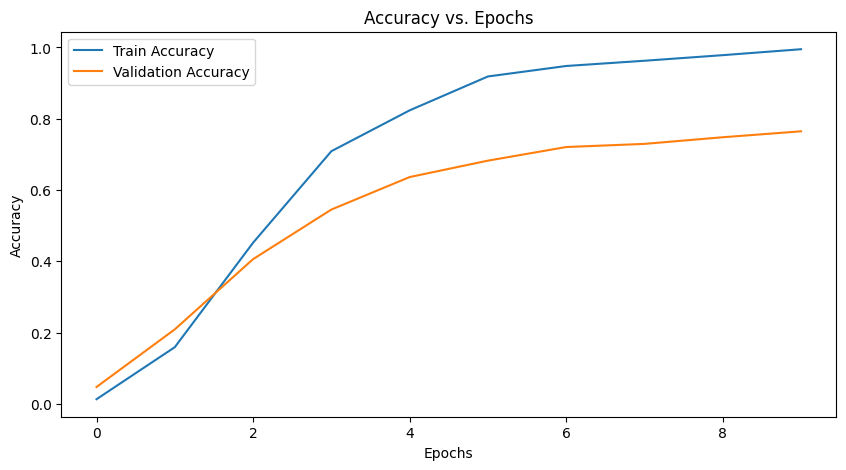

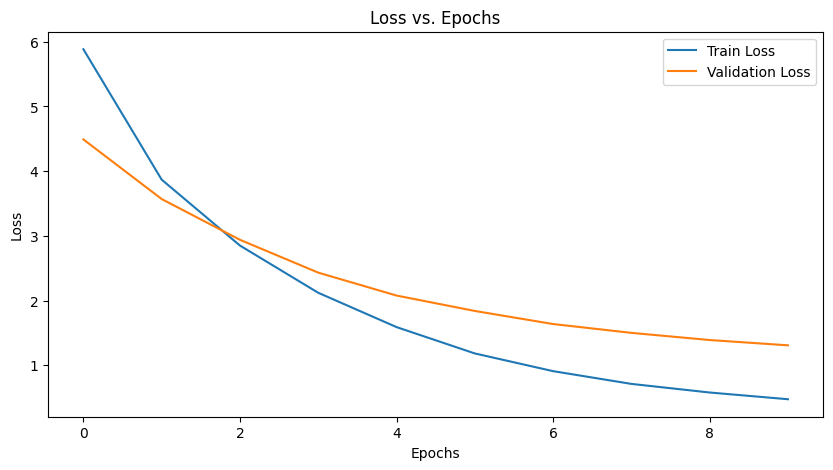

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [9]:
test_dataset = Flowers102(root=data_dir, split="test", download=True, transform=transform_pipeline)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Test dataset loaded!")

Test dataset loaded!


In [10]:
def evaluate_model(model, dataloader, criterion, dataset_name="Test"):
    model.eval()
    running_loss, correct = 0.0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct.double() / len(dataloader.dataset)

    print(f"{dataset_name} Loss: {epoch_loss:.4f}, {dataset_name} Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc


In [23]:
train_loss, train_acc = evaluate_model(model, train_loader, criterion, "Train")
val_loss, val_acc = evaluate_model(model, val_loader, criterion, "Validation")
test_loss, test_acc = evaluate_model(model, test_loader, criterion, "Test")

Train Loss: 0.3033, Train Accuracy: 0.9971
Validation Loss: 1.3099, Validation Accuracy: 0.7618
Test Loss: 1.3965, Test Accuracy: 0.7461


In [25]:
print("\n--- Final Results ---")
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


--- Final Results ---
Training Loss: 0.3033, Training Accuracy: 0.9971
Validation Loss: 1.3099, Validation Accuracy: 0.7618
Test Loss: 1.3965, Test Accuracy: 0.7461


In [11]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

for param in resnet50.parameters():
    param.requires_grad = False
for param in vgg16.parameters():
    param.requires_grad = False

num_classes = 102

resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

resnet50 = resnet50.to(device)
vgg16 = vgg16.to(device)

print("ResNet50 and VGG16 models loaded and modified!")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 218MB/s] 


ResNet50 and VGG16 models loaded and modified!


In [12]:
optimizer_resnet50 = torch.optim.Adam(resnet50.fc.parameters(), lr=0.001)
optimizer_vgg16 = torch.optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

print("\nTraining ResNet50...")
train_loss_resnet50, val_loss_resnet50, train_acc_resnet50, val_acc_resnet50 = train_and_validate(
    resnet50, train_loader, val_loader, criterion, optimizer_resnet50, num_epochs=10
)

print("\nTraining VGG16...")
train_loss_vgg16, val_loss_vgg16, train_acc_vgg16, val_acc_vgg16 = train_and_validate(
    vgg16, train_loader, val_loader, criterion, optimizer_vgg16, num_epochs=10
)



Training ResNet50...
Epoch 1/10
Train Loss: 4.3768, Train Acc: 0.1382
Val Loss: 3.8043, Val Acc: 0.5353
Epoch 2/10
Train Loss: 3.0884, Train Acc: 0.8745
Val Loss: 3.0478, Val Acc: 0.7539
Epoch 3/10
Train Loss: 2.1472, Train Acc: 0.9686
Val Loss: 2.5052, Val Acc: 0.7922
Epoch 4/10
Train Loss: 1.4982, Train Acc: 0.9941
Val Loss: 2.1145, Val Acc: 0.8049
Epoch 5/10
Train Loss: 1.0494, Train Acc: 0.9961
Val Loss: 1.8860, Val Acc: 0.8186
Epoch 6/10
Train Loss: 0.7839, Train Acc: 0.9990
Val Loss: 1.6707, Val Acc: 0.8294
Epoch 7/10
Train Loss: 0.6005, Train Acc: 1.0000
Val Loss: 1.5580, Val Acc: 0.8216
Epoch 8/10
Train Loss: 0.4760, Train Acc: 1.0000
Val Loss: 1.4197, Val Acc: 0.8294
Epoch 9/10
Train Loss: 0.3628, Train Acc: 1.0000
Val Loss: 1.3236, Val Acc: 0.8324
Epoch 10/10
Train Loss: 0.2903, Train Acc: 1.0000
Val Loss: 1.2713, Val Acc: 0.8422

Training VGG16...
Epoch 1/10
Train Loss: 3.8077, Train Acc: 0.1814
Val Loss: 2.1817, Val Acc: 0.5971
Epoch 2/10
Train Loss: 1.3570, Train Acc: 0.7

In [13]:
def to_cpu_numpy(data):
    if torch.is_tensor(data):  
        return data.cpu().numpy()
    return [x.cpu().numpy() if torch.is_tensor(x) else x for x in data]

def plot_results(train_acc_resnet50, val_acc_resnet50, train_acc_vgg16, val_acc_vgg16,
                 train_acc_mobilenet, val_acc_mobilenet, 
                 train_loss_resnet50, val_loss_resnet50, train_loss_vgg16, val_loss_vgg16,
                 train_loss_mobilenet, val_loss_mobilenet):
    
    train_acc_resnet50 = to_cpu_numpy(train_acc_resnet50)
    val_acc_resnet50 = to_cpu_numpy(val_acc_resnet50)
    train_acc_vgg16 = to_cpu_numpy(train_acc_vgg16)
    val_acc_vgg16 = to_cpu_numpy(val_acc_vgg16)
    train_acc_mobilenet = to_cpu_numpy(train_acc_mobilenet)
    val_acc_mobilenet = to_cpu_numpy(val_acc_mobilenet)

    train_loss_resnet50 = to_cpu_numpy(train_loss_resnet50)
    val_loss_resnet50 = to_cpu_numpy(val_loss_resnet50)
    train_loss_vgg16 = to_cpu_numpy(train_loss_vgg16)
    val_loss_vgg16 = to_cpu_numpy(val_loss_vgg16)
    train_loss_mobilenet = to_cpu_numpy(train_loss_mobilenet)
    val_loss_mobilenet = to_cpu_numpy(val_loss_mobilenet)
    
    epochs = len(train_acc_resnet50)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_acc_resnet50, label="ResNet50 Train Accuracy", linestyle="--")
    plt.plot(range(1, epochs+1), val_acc_resnet50, label="ResNet50 Validation Accuracy")

    plt.plot(range(1, epochs+1), train_acc_vgg16, label="VGG16 Train Accuracy", linestyle="--")
    plt.plot(range(1, epochs+1), val_acc_vgg16, label="VGG16 Validation Accuracy")

    plt.plot(range(1, epochs+1), train_acc_mobilenet, label="MobileNetV2 Train Accuracy", linestyle="--")
    plt.plot(range(1, epochs+1), val_acc_mobilenet, label="MobileNetV2 Validation Accuracy")

    plt.title("Model Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_loss_resnet50, label="ResNet50 Train Loss", linestyle="--")
    plt.plot(range(1, epochs+1), val_loss_resnet50, label="ResNet50 Validation Loss")

    plt.plot(range(1, epochs+1), train_loss_vgg16, label="VGG16 Train Loss", linestyle="--")
    plt.plot(range(1, epochs+1), val_loss_vgg16, label="VGG16 Validation Loss")

    plt.plot(range(1, epochs+1), train_loss_mobilenet, label="MobileNetV2 Train Loss", linestyle="--")
    plt.plot(range(1, epochs+1), val_loss_mobilenet, label="MobileNetV2 Validation Loss")

    plt.title("Model Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

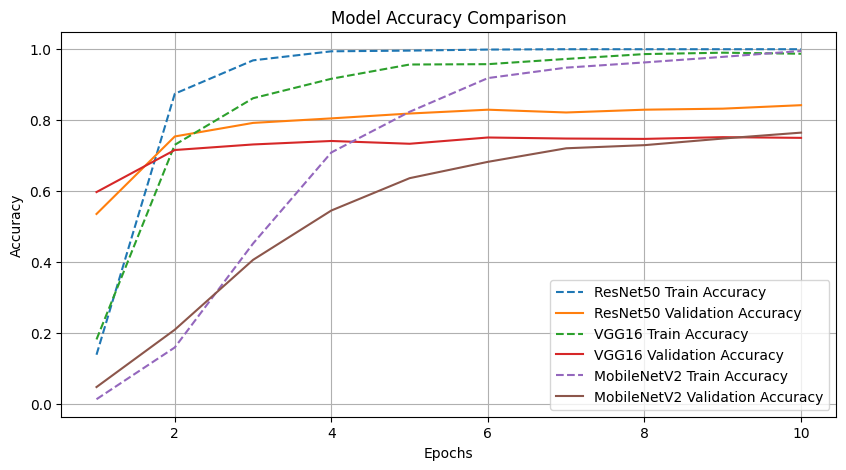

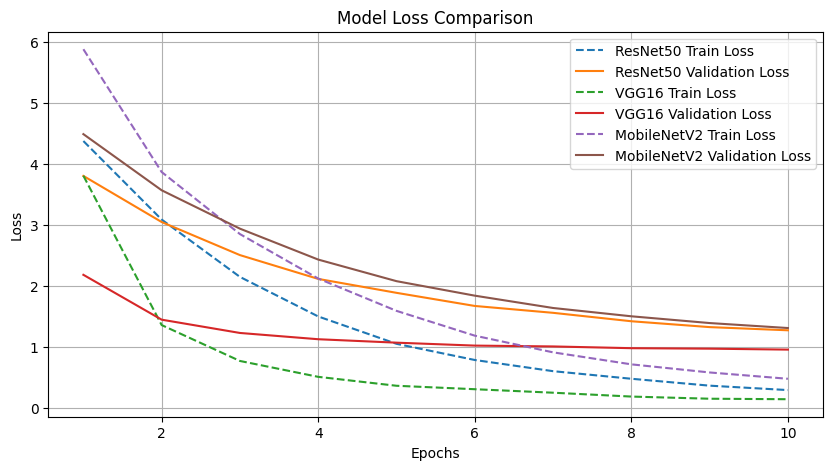

In [14]:
plot_results(
    train_acc_resnet50=train_acc_resnet50, val_acc_resnet50=val_acc_resnet50,
    train_acc_vgg16=train_acc_vgg16, val_acc_vgg16=val_acc_vgg16,
    train_acc_mobilenet=train_acc, val_acc_mobilenet=val_acc,
    train_loss_resnet50=train_loss_resnet50, val_loss_resnet50=val_loss_resnet50,
    train_loss_vgg16=train_loss_vgg16, val_loss_vgg16=val_loss_vgg16,
    train_loss_mobilenet=train_loss, val_loss_mobilenet=val_loss
)

In [15]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, learnable_params

resnet50_params = count_parameters(resnet50)
vgg16_params = count_parameters(vgg16)
mobilenet_params = count_parameters(model)  

print("\n--- Parameter Comparison ---")
print(f"ResNet50: Total = {resnet50_params[0]}, Learnable = {resnet50_params[1]}")
print(f"VGG16: Total = {vgg16_params[0]}, Learnable = {vgg16_params[1]}")
print(f"MobileNetV2: Total = {mobilenet_params[0]}, Learnable = {mobilenet_params[1]}")



--- Parameter Comparison ---
ResNet50: Total = 23717030, Learnable = 208998
VGG16: Total = 134678438, Learnable = 417894
MobileNetV2: Total = 3504872, Learnable = 1281000


In [16]:
print("\n--- Final Results ---")
print("ResNet50:")
print(f"Train Loss: {train_loss_resnet50[-1]:.4f}, Train Acc: {train_acc_resnet50[-1]:.4f}")
print(f"Val Loss: {val_loss_resnet50[-1]:.4f}, Val Acc: {val_acc_resnet50[-1]:.4f}")

print("\nVGG16:")
print(f"Train Loss: {train_loss_vgg16[-1]:.4f}, Train Acc: {train_acc_vgg16[-1]:.4f}")
print(f"Val Loss: {val_loss_vgg16[-1]:.4f}, Val Acc: {val_acc_vgg16[-1]:.4f}")

print("\nMobileNetV2:")
print(f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}")
print(f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")



--- Final Results ---
ResNet50:
Train Loss: 0.2903, Train Acc: 1.0000
Val Loss: 1.2713, Val Acc: 0.8422

VGG16:
Train Loss: 0.1403, Train Acc: 0.9873
Val Loss: 0.9544, Val Acc: 0.7500

MobileNetV2:
Train Loss: 0.4756, Train Acc: 0.9951
Val Loss: 1.3084, Val Acc: 0.7647


In [17]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion, "Test")
resnet50_loss, resnet50_acc = evaluate_model(resnet50, test_loader, criterion, "Test")
vgg16_loss, vgg16_acc = evaluate_model(vgg16, test_loader, criterion, "Test")

Test Loss: 1.4027, Test Accuracy: 0.7421
Test Loss: 1.3303, Test Accuracy: 0.8192
Test Loss: 1.0484, Test Accuracy: 0.7333


In [18]:
print("\n--- Final Results ---")
print("ResNet50:")
print(f"Test Loss: {test_loss}, test Acc: {test_acc}")


print("\nVGG16:")
print(f"Test Loss: {vgg16_loss}, test Acc: {vgg16_acc}")

print("\nMobileNetV2:")
print(f"Test Loss: {resnet50_loss}, test Acc: {resnet50_acc}")


--- Final Results ---
ResNet50:
Test Loss: 1.4027172064932405, test Acc: 0.7420718816067654

VGG16:
Test Loss: 1.0483768751214997, test Acc: 0.7332899658481055

MobileNetV2:
Test Loss: 1.33027304825036, test Acc: 0.8191575865994472


### Model Comparison Summary

| Model          | Total Params | Learnable Params | Val Accuracy | Test Accuracy |
|----------------|--------------|------------------|--------------|---------------|
| **ResNet50**   | 23.7M        | 209K             | **84.22%**   | 74.21%        |
| **VGG16**      | **134.6M**   | 417K             | 75.00%       | 73.33%        |
| **MobileNetV2**| **3.5M**     | **1.28M**        | 76.47%       | **81.92%**    |

---

**MobileNetV2**:
   - **Best test accuracy** (81.92%) with the smallest total parameters.  
   - Lightweight and generalizes well, making it the most efficient choice.

**ResNet50**:
   - **Highest validation accuracy** (84.22%) but lower test performance (74.21%).  
   - Good balance between performance and efficiency.

**VGG16**:
   - Very high parameter count but **overfits** with lower test accuracy (73.33%).  
   - Least efficient and struggles to generalize.

---

**MobileNetV2** is the best choice for efficiency and real-world deployment.  
**ResNet50** offers good accuracy with fewer parameters.  
**VGG16** is not recommended due to inefficiency and overfitting.

In [19]:
mobilenet_scratch = models.mobilenet_v2(weights=None)  
num_classes = 102
mobilenet_scratch.classifier[1] = nn.Linear(mobilenet_scratch.classifier[1].in_features, num_classes)
mobilenet_scratch = mobilenet_scratch.to(device)

optimizer_scratch = torch.optim.Adam(mobilenet_scratch.parameters(), lr=0.001)

In [20]:
print("\n--- Training MobileNetV2 From Scratch ---")
train_loss_scratch, val_loss_scratch, train_acc_scratch, val_acc_scratch = train_and_validate(
    mobilenet_scratch, train_loader, val_loader, criterion, optimizer_scratch, num_epochs=10
)


--- Training MobileNetV2 From Scratch ---
Epoch 1/10
Train Loss: 4.8753, Train Acc: 0.0098
Val Loss: 4.9795, Val Acc: 0.0098
Epoch 2/10
Train Loss: 4.4343, Train Acc: 0.0333
Val Loss: 5.2237, Val Acc: 0.0098
Epoch 3/10
Train Loss: 4.0142, Train Acc: 0.0549
Val Loss: 4.9028, Val Acc: 0.0618
Epoch 4/10
Train Loss: 3.7481, Train Acc: 0.0863
Val Loss: 4.0094, Val Acc: 0.0922
Epoch 5/10
Train Loss: 3.3952, Train Acc: 0.1127
Val Loss: 3.9160, Val Acc: 0.1157
Epoch 6/10
Train Loss: 3.1374, Train Acc: 0.1686
Val Loss: 3.9308, Val Acc: 0.1186
Epoch 7/10
Train Loss: 2.9892, Train Acc: 0.2137
Val Loss: 3.9348, Val Acc: 0.1225
Epoch 8/10
Train Loss: 2.8111, Train Acc: 0.2304
Val Loss: 4.2553, Val Acc: 0.0775
Epoch 9/10
Train Loss: 2.7137, Train Acc: 0.2529
Val Loss: 3.9372, Val Acc: 0.1314
Epoch 10/10
Train Loss: 2.5498, Train Acc: 0.2755
Val Loss: 3.7384, Val Acc: 0.1294


In [22]:
print("\n--- Evaluating MobileNetV2 From Scratch on Test Set ---")
test_loss_scratch, test_acc_scratch = evaluate_model(mobilenet_scratch, test_loader, criterion, "Test")


--- Evaluating MobileNetV2 From Scratch on Test Set ---
Test Loss: 4.0117, Test Accuracy: 0.1177


In [23]:
print("\n--- Final Comparison Between MobileNetV2 Models ---")
print(f"MobileNetV2 (Transfer Learning) Test Accuracy: {test_acc:.4f}")
print(f"MobileNetV2 (From Scratch) Test Accuracy: {test_acc_scratch:.4f}")


--- Final Comparison Between MobileNetV2 Models ---
MobileNetV2 (Transfer Learning) Test Accuracy: 0.7421
MobileNetV2 (From Scratch) Test Accuracy: 0.1177


In [26]:
print("\nMobileNetV2:")
print(f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}")
print(f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")
print(f"MobileNetV2 (Transfer Learning) Test Accuracy: {test_acc:.4f}")
print("\nMobileNetV2 from scratch:")
print(f"Train Loss: {train_loss_scratch[-1]:.4f}, Train Acc: {train_acc_scratch[-1]:.4f}")
print(f"Val Loss: {val_loss_scratch[-1]:.4f}, Val Acc: {val_acc_scratch[-1]:.4f}")
print(f"MobileNetV2 (Transfer Learning) Test Accuracy: {test_acc_scratch:.4f}")


MobileNetV2:
Train Loss: 0.4756, Train Acc: 0.9951
Val Loss: 1.3084, Val Acc: 0.7647
MobileNetV2 (Transfer Learning) Test Accuracy: 0.7421

MobileNetV2 from scratch:
Train Loss: 2.5498, Train Acc: 0.2755
Val Loss: 3.7384, Val Acc: 0.1294
MobileNetV2 (Transfer Learning) Test Accuracy: 0.1177


### Model Comparison Summary

| Model                        | Val Accuracy | Test Accuracy |
|------------------------------|--------------|---------------|
| **MobileNetV2 (Transfer Learning)** | **76.47%**   | **74.21%**    |
| **MobileNetV2 (From Scratch)**      | 12.94%       | 11.77%      
nsights:
- **Transfer Learning**: Achieves **74.21% test accuracy** by leveraging pre-trained weights, ensuring faster convergence and better performance.
- **From Scratch**: Struggles to learn, with only **11.77% test accuracy**, due to insufficient data and training time.

---

### Conclusion:
**Transfer Learning** is far superior and recommended for small datasets like Oxford 102 Flower.
ike Oxford 102 Flower.
